In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
from astropy import time as t

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
import poliastro

import urllib.request
import json
from collections import OrderedDict

import emcee

# Loading multiple files with a SINGLE satellite

In [161]:
c = 299792.458  # km/s

def get_redshift(f_c, f_m):
    z = (f_m - f_c)/f_c
    return z
    
def get_v_radial(f_c, f_m):
    v_r = c * get_redshift(f_c, f_m)
    return v_r

In [4]:
file_list = ['first_test/001_20190721T052832_jena.json',
             'first_test/001_20190721T052821_leipzig.json',
             'first_test/001_20190721T052801_settrup.json',
             'first_test/001_20190721T052806_stuttgart.json']

N = len(file_list)

In [5]:
raw_data = []

for filename in file_list:
    with open( filename, 'r') as myfile:
        data=myfile.read()
        raw_data.append(data)

In [6]:
json_files = []

for i in range(N):
    obj = json.loads(raw_data[i])
    json_files.append(obj)

In [ ]:
json_files[0]

In [8]:
obj = json_files[0]
print(obj.keys())

dict_keys(['meta', 'groundstation', 'satellite', 'data'])


In [9]:
obj['groundstation']

{'gs_id': None,
 'gs_name': 'jena',
 'gs_lon': 11.56886,
 'gs_lat': 50.91847,
 'gs_alt': 130.0}

In [10]:
gs_geodetic_locs = []

for i in range(N):
    gs_geodetic_locs.append( json_files[i]['groundstation'])


In [12]:
for i in range(N):
    print(gs_geodetic_locs[i])

{'gs_id': None, 'gs_name': 'jena', 'gs_lon': 11.56886, 'gs_lat': 50.91847, 'gs_alt': 130.0}
{'gs_id': None, 'gs_name': 'leipzig', 'gs_lon': 12.338261, 'gs_lat': 51.336569, 'gs_alt': 80.0}
{'gs_id': None, 'gs_name': 'settrup', 'gs_lon': 7.6289, 'gs_lat': 52.49356, 'gs_alt': 40.0}
{'gs_id': None, 'gs_name': 'stuttgart', 'gs_lon': 9.2356, 'gs_lat': 48.777, 'gs_alt': 230.0}


In [13]:
obj['meta']

{'file_name': 'D:/20190719_21/jena/SDRSharp_20190721_052832Z_137500000Hz_IQ.wav',
 'file_time_system': 1563679712.0,
 'file_f_center': 137500000,
 'file_samplerate': 2048000,
 'file_created': 1564523756.2432327}

In [63]:
f_c = obj['data'][0]['channel_f_center']

In [64]:
f_c

137100000

In [65]:
obj['satellite']

[{'sat_ID': 1, 'sat_name': 'NOAA-19'}]

In [ ]:
obj['data']

In [67]:
obj['data'][0].keys()

dict_keys(['sat_id', 'channel', 'channel_bandwidth', 'channel_f_center', 'stream'])

In [68]:
for i in range(N):
    print(json_files[i]['data'][0]['sat_id'])
    print(json_files[i]['data'][0]['stream'][0])
    print(json_files[i]['data'][0]['stream'][-1])
    print()

1
{'id': 0, 'time_system': 1563679712.0, 'time_gnss': None, 'f': 137103187.75947043, 'f_doppler': 3187.7594704329967, 'r': None}
{'id': 395, 'time_system': 1563680107.0, 'time_gnss': None, 'f': 137098401.4546298, 'f_doppler': -1598.5453701913357, 'r': None}

1
{'id': 0, 'time_system': 1563679701.0, 'time_gnss': None, 'f': 137102985.0495376, 'f_doppler': 2985.0495375990868, 'r': None}
{'id': 400, 'time_system': 1563680101.0, 'time_gnss': None, 'f': 137098066.2063926, 'f_doppler': -1933.7936074137688, 'r': None}

1
{'id': 0, 'time_system': 1563679681.0, 'time_gnss': None, 'f': 137103232.47975314, 'f_doppler': 3232.479753136635, 'r': None}
{'id': 388, 'time_system': 1563680069.0, 'time_gnss': None, 'f': 137098207.14077938, 'f_doppler': -1792.85922062397, 'r': None}

1
{'id': 0, 'time_system': 1563679686.0, 'time_gnss': None, 'f': 137103562.64867875, 'f_doppler': 3562.6486787497997, 'r': None}
{'id': 391, 'time_system': 1563680077.0, 'time_gnss': None, 'f': 137098827.40861362, 'f_doppler':

In [70]:
tau = []
z = []

for i in range(N):
    
    print(json_files[i]['data'][0]['sat_id'])
    stream = json_files[i]['data'][0]['stream']
    
    aux_tau = []
    aux_z   = []
    
    for s in stream:
        aux_tau.append( float(s['time_system']))
        aux_z.append( get_redshift(f_c, float(s['f']) ))

    print(len(aux_z))
    tau.append(aux_tau)
    z.append(aux_z)

        

1
396
1
401
1
389
1
392


In [71]:
for i in range(N):
    print(len(tau[i]))

396
401
389
392


### Doppler Shift measured by Ground Stations

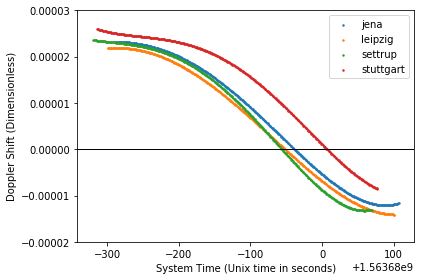

In [102]:
fig = plt.figure(figsize=(6,4))
plt.axhline(0, c="k", lw=1)

for i in range(N):
    
    label = gs_geodetic_locs[i]['gs_name']
    plt.scatter(tau[i], z[i], s=2, label=label)
    
plt.ylim(-2e-5,3e-5)
plt.xlabel("System Time (Unix time in seconds)")
plt.ylabel("Doppler Shift (Dimensionless)")
plt.legend(loc=0)

plt.tight_layout()
plt.savefig("first_test/measured_doppler_shift.png")

### Calculating GS positions and velocities in the GeoCentric Reference System

In [91]:
gs_geodetic_locs

[{'gs_id': None,
  'gs_name': 'jena',
  'gs_lon': 11.56886,
  'gs_lat': 50.91847,
  'gs_alt': 130.0},
 {'gs_id': None,
  'gs_name': 'leipzig',
  'gs_lon': 12.338261,
  'gs_lat': 51.336569,
  'gs_alt': 80.0},
 {'gs_id': None,
  'gs_name': 'settrup',
  'gs_lon': 7.6289,
  'gs_lat': 52.49356,
  'gs_alt': 40.0},
 {'gs_id': None,
  'gs_name': 'stuttgart',
  'gs_lon': 9.2356,
  'gs_lat': 48.777,
  'gs_alt': 230.0}]

In [105]:
GS = []

for i in range(N):
    lon = gs_geodetic_locs[i]['gs_lon']
    lat = gs_geodetic_locs[i]['gs_lat']
    alt = gs_geodetic_locs[i]['gs_alt']
    
    gs = coord.EarthLocation(lon, lat, alt)
    
    GS.append(gs)

In [106]:
GS 

[<EarthLocation (3947302.485977, 808029.34688436, 4927932.57836334) m>,
 <EarthLocation (3900688.39630275, 853216.64217843, 4957085.63237295) m>,
 <EarthLocation (3857117.25251054, 516629.62143337, 5036460.03219459) m>,
 <EarthLocation (4156679.23402729, 675885.84844335, 4774425.562896) m>]

In [173]:
tau[0][:10]

[1563679712.0,
 1563679713.0,
 1563679714.0,
 1563679715.0,
 1563679716.0,
 1563679717.0,
 1563679718.0,
 1563679719.0,
 1563679720.0,
 1563679721.0]

In [119]:
t.Time(1563679811.0, format='unix', scale="utc")

<Time object: scale='utc' format='unix' value=1563679811.0>

In [120]:
tau_astropytime = []

for i in range(N):
    aux = []
    for aux_t in tau[i]:
        theta = t.Time(aux_t, format='unix', scale='utc')
        aux.append(theta)
    tau_astropytime.append(aux)

In [131]:
print(t.Time.now())

2019-07-31 19:16:36.520122


In [133]:
GS_gcrs_positions = []
GS_gcrs_velocities = []

for  i in range(N):
    aux_pos = []
    aux_vel = []
    
    print("iteration {} starts at time {}".format(i, t.Time.now()))
    for t0 in tau_astropytime[i]:
        p,v = GS[0].get_gcrs_posvel(obstime= t0)
        aux_pos.append(p)
        aux_vel.append(v)
    
    print("iteration {} ends at time {}".format(i, t.Time.now()))
    
    GS_gcrs_positions.append(aux_pos)
    GS_gcrs_velocities.append(aux_vel)

iteration 0 starts at time 2019-07-31 19:18:02.048991
iteration 0 ends at time 2019-07-31 19:19:37.966385
iteration 1 starts at time 2019-07-31 19:19:37.967225
iteration 1 ends at time 2019-07-31 19:21:15.100529
iteration 2 starts at time 2019-07-31 19:21:15.101580
iteration 2 ends at time 2019-07-31 19:23:02.761106
iteration 3 starts at time 2019-07-31 19:23:02.761779
iteration 3 ends at time 2019-07-31 19:24:42.970084


In [177]:
GS_gcrs_positions[0][:10]

[<CartesianRepresentation (x, y, z) in m
     (4035733.13268396, 145414.70323006, 4920400.43937277)>,
 <CartesianRepresentation (x, y, z) in m
     (4035722.51179125, 145708.32183512, 4920400.46447655)>,
 <CartesianRepresentation (x, y, z) in m
     (4035711.86943215, 146001.93966102, 4920400.48961992)>,
 <CartesianRepresentation (x, y, z) in m
     (4035701.20577448, 146295.55675354, 4920400.5148105)>,
 <CartesianRepresentation (x, y, z) in m
     (4035690.52060465, 146589.17294483, 4920400.54003305)>,
 <CartesianRepresentation (x, y, z) in m
     (4035679.81402944, 146882.78846377, 4920400.56529519)>,
 <CartesianRepresentation (x, y, z) in m
     (4035669.08612517, 147176.40320355, 4920400.59059691)>,
 <CartesianRepresentation (x, y, z) in m
     (4035658.33667821, 147470.01708788, 4920400.61593059)>,
 <CartesianRepresentation (x, y, z) in m
     (4035647.56590218, 147763.63020831, 4920400.64132675)>,
 <CartesianRepresentation (x, y, z) in m
     (4035636.77373604, 148057.2425801, 49

In [176]:
GS_gcrs_velocities[0][:10]

[<CartesianRepresentation (x, y, z) in m / s
     (-10.61036549, 293.61894124, 0.02509544)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.63158776, 293.61823837, 0.02511976)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.65305416, 293.61742869, 0.02515935)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.67452056, 293.61669531, 0.02522183)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.6956055, 293.61602296, 0.02523852)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.71730077, 293.61509121, 0.02527812)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.73866036, 293.61432731, 0.02531007)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.76003521, 293.61356341, 0.02537255)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.78151686, 293.61278425, 0.02541214)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.802968, 293.61188303, 0.0254441)>]

### Now we have the Ground Station location in XYZ in the Geocentric Inertial System.

Regading, this is the System where Satellite coordinates are measured.

In [138]:
for i in range(N):
    print(len(GS_gcrs_positions[i]), len(GS_gcrs_velocities[i]), len(tau_astropytime[i]))

396 396 396
401 401 401
389 389 389
392 392 392


In [141]:
GS_gcrs_positions[1][0]

<CartesianRepresentation (x, y, z) in m
    (4035848.54949027, 142184.84794311, 4920400.16588212)>

### Initial position guess:

Well, let's try an XYZ-VxVyVz approximation to the orbital parameters, instead the classic elements.

1. Find average location of Ground Stations: GS_av
2. Extend this vector into space something like 500 km: R0
3. Find some points in a circle into a radius of 1000 km. The circle is centered at R0, in the plane defined by the vector GS_av
4. Define initial velocities towards R0 (or something tangential to Earths Surface).


In [166]:
GS_0x = []
GS_0y = []
GS_0z = []

for i in range(N):
    x, y, z = GS_gcrs_positions[i][0].xyz
    
    GS_0x.append(x.value)
    GS_0y.append(y.value)
    GS_0z.append(z.value)
    
GS_0xav = np.mean(GS_0x)
GS_0yav = np.mean(GS_0y)
GS_0zav = np.mean(GS_0z)

In [167]:
GS_gcrs_positions[0][0]

<CartesianRepresentation (x, y, z) in m
    (4035733.13268396, 145414.70323006, 4920400.43937277)>

In [168]:
GS_av = (GS_0xav, GS_0yav, GS_0zav)
print(R0)

(4035908.8008950613, 140423.01365830595, 4920400.021755013)


In [169]:
N_rw = 60 # Number of Random Walkers

In [170]:
(X0 **2 + Y0 **2 + Z0 **2)**0.5

6365423.383090383